#  Buoi 12 | 29/05/2021 | Neural Network with Numpy

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1-yp1injeoB7Zx7OLULlhuY6QExTNhUOR?usp=sharing)

## Import các thư viện cần thiết

In [44]:
import numpy as np
import os
import platform
import matplotlib.pyplot as plt


from builtins import range
from six.moves import cPickle as pickle
from imageio import imread

## Load data

In [30]:
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == "2":
        return pickle.load(f)
    elif version[0] == "3":
        return pickle.load(f, encoding="latin1")
    raise ValueError("invalid python version: {}".format(version))


def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, "rb") as f:
        datadict = load_pickle(f)
        X = datadict["data"]
        Y = datadict["labels"]
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y


def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, "data_batch_%d" % (b,))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, "test_batch"))
    return Xtr, Ytr, Xte, Yte


def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, subtract_mean=True):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for classifiers. These are the same steps as we used for the SVM, but
    condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = os.path.join(os.path.dirname(__file__), "/content/drive/MyDrive/TÀI LIỆU HỌC TẬP ĐẠI HỌC 2019-2023/PYTHON & ML 02/BUỔI 12 29 05 2021/data/cifar-10-batches-py")
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    if subtract_mean:
        mean_image = np.mean(X_train, axis=0)
        X_train -= mean_image
        X_val -= mean_image
        X_test -= mean_image

    # Transpose so that channels come first
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    X_test = X_test.transpose(0, 3, 1, 2).copy()

    # Package data into a dictionary
    return {
        "X_train": X_train,
        "y_train": y_train,
        "X_val": X_val,
        "y_val": y_val,
        "X_test": X_test,
        "y_test": y_test,
    }


def load_tiny_imagenet(path, dtype=np.float32, subtract_mean=True):
    """
    Load TinyImageNet. Each of TinyImageNet-100-A, TinyImageNet-100-B, and
    TinyImageNet-200 have the same directory structure, so this can be used
    to load any of them.

    Inputs:
    - path: String giving path to the directory to load.
    - dtype: numpy datatype used to load the data.
    - subtract_mean: Whether to subtract the mean training image.

    Returns: A dictionary with the following entries:
    - class_names: A list where class_names[i] is a list of strings giving the
      WordNet names for class i in the loaded dataset.
    - X_train: (N_tr, 3, 64, 64) array of training images
    - y_train: (N_tr,) array of training labels
    - X_val: (N_val, 3, 64, 64) array of validation images
    - y_val: (N_val,) array of validation labels
    - X_test: (N_test, 3, 64, 64) array of testing images.
    - y_test: (N_test,) array of test labels; if test labels are not available
      (such as in student code) then y_test will be None.
    - mean_image: (3, 64, 64) array giving mean training image
    """
    # First load wnids
    with open(os.path.join(path, "wnids.txt"), "r") as f:
        wnids = [x.strip() for x in f]

    # Map wnids to integer labels
    wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}

    # Use words.txt to get names for each class
    with open(os.path.join(path, "words.txt"), "r") as f:
        wnid_to_words = dict(line.split("\t") for line in f)
        for wnid, words in wnid_to_words.items():
            wnid_to_words[wnid] = [w.strip() for w in words.split(",")]
    class_names = [wnid_to_words[wnid] for wnid in wnids]

    # Next load training data.
    X_train = []
    y_train = []
    for i, wnid in enumerate(wnids):
        if (i + 1) % 20 == 0:
            print("loading training data for synset %d / %d" % (i + 1, len(wnids)))
        # To figure out the filenames we need to open the boxes file
        boxes_file = os.path.join(path, "train", wnid, "%s_boxes.txt" % wnid)
        with open(boxes_file, "r") as f:
            filenames = [x.split("\t")[0] for x in f]
        num_images = len(filenames)

        X_train_block = np.zeros((num_images, 3, 64, 64), dtype=dtype)
        y_train_block = wnid_to_label[wnid] * np.ones(num_images, dtype=np.int64)
        for j, img_file in enumerate(filenames):
            img_file = os.path.join(path, "train", wnid, "images", img_file)
            img = imread(img_file)
            if img.ndim == 2:
                ## grayscale file
                img.shape = (64, 64, 1)
            X_train_block[j] = img.transpose(2, 0, 1)
        X_train.append(X_train_block)
        y_train.append(y_train_block)

    # We need to concatenate all training data
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)

    # Next load validation data
    with open(os.path.join(path, "val", "val_annotations.txt"), "r") as f:
        img_files = []
        val_wnids = []
        for line in f:
            img_file, wnid = line.split("\t")[:2]
            img_files.append(img_file)
            val_wnids.append(wnid)
        num_val = len(img_files)
        y_val = np.array([wnid_to_label[wnid] for wnid in val_wnids])
        X_val = np.zeros((num_val, 3, 64, 64), dtype=dtype)
        for i, img_file in enumerate(img_files):
            img_file = os.path.join(path, "val", "images", img_file)
            img = imread(img_file)
            if img.ndim == 2:
                img.shape = (64, 64, 1)
            X_val[i] = img.transpose(2, 0, 1)

    # Next load test images
    # Students won't have test labels, so we need to iterate over files in the
    # images directory.
    img_files = os.listdir(os.path.join(path, "test", "images"))
    X_test = np.zeros((len(img_files), 3, 64, 64), dtype=dtype)
    for i, img_file in enumerate(img_files):
        img_file = os.path.join(path, "test", "images", img_file)
        img = imread(img_file)
        if img.ndim == 2:
            img.shape = (64, 64, 1)
        X_test[i] = img.transpose(2, 0, 1)

    y_test = None
    y_test_file = os.path.join(path, "test", "test_annotations.txt")
    if os.path.isfile(y_test_file):
        with open(y_test_file, "r") as f:
            img_file_to_wnid = {}
            for line in f:
                line = line.split("\t")
                img_file_to_wnid[line[0]] = line[1]
        y_test = [wnid_to_label[img_file_to_wnid[img_file]] for img_file in img_files]
        y_test = np.array(y_test)

    mean_image = X_train.mean(axis=0)
    if subtract_mean:
        X_train -= mean_image[None]
        X_val -= mean_image[None]
        X_test -= mean_image[None]

    return {
        "class_names": class_names,
        "X_train": X_train,
        "y_train": y_train,
        "X_val": X_val,
        "y_val": y_val,
        "X_test": X_test,
        "y_test": y_test,
        "class_names": class_names,
        "mean_image": mean_image,
    }


def load_models(models_dir):
    """
    Load saved models from disk. This will attempt to unpickle all files in a
    directory; any files that give errors on unpickling (such as README.txt)
    will be skipped.

    Inputs:
    - models_dir: String giving the path to a directory containing model files.
      Each model file is a pickled dictionary with a 'model' field.

    Returns:
    A dictionary mapping model file names to models.
    """
    models = {}
    for model_file in os.listdir(models_dir):
        with open(os.path.join(models_dir, model_file), "rb") as f:
            try:
                models[model_file] = load_pickle(f)["model"]
            except pickle.UnpicklingError:
                continue
    return models


def load_imagenet_val(num=None):
    """Load a handful of validation images from ImageNet.

    Inputs:
    - num: Number of images to load (max of 25)

    Returns:
    - X: numpy array with shape [num, 224, 224, 3]
    - y: numpy array of integer image labels, shape [num]
    - class_names: dict mapping integer label to class name
    """
    imagenet_fn = os.path.join(
        os.path.dirname(__file__), "datasets/imagenet_val_25.npz"
    )
    if not os.path.isfile(imagenet_fn):
        print("file %s not found" % imagenet_fn)
        print("Run the following:")
        print("cd cs231n/datasets")
        print("bash get_imagenet_val.sh")
        assert False, "Need to download imagenet_val_25.npz"

    # modify the default parameters of np.load
    # https://stackoverflow.com/questions/55890813/how-to-fix-object-arrays-cannot-be-loaded-when-allow-pickle-false-for-imdb-loa
    np_load_old = np.load
    np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
    f = np.load(imagenet_fn)
    np.load = np_load_old
    X = f["X"]
    y = f["y"]
    class_names = f["label_map"].item()
    if num is not None:
        X = X[:num]
        y = y[:num]
    return X, y, class_names


## data shallow

In [31]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):

    # Load the raw CIFAR-10 data
    cifar10_dir = '/content/drive/MyDrive/TÀI LIỆU HỌC TẬP ĐẠI HỌC 2019-2023/PYTHON & ML 02/BUỔI 12 29 05 2021/data/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test

## Layers

In [4]:
def softmax_loss(x, y):
    N = x.shape[0]
    scores = x - np.max(x, axis=1, keepdims=True)
    sum_exp = np.exp(scores).sum(axis=1, keepdims=True)
    softmax_matrix = np.exp(scores)/sum_exp

    loss = np.sum(-np.log(softmax_matrix[np.arange(N), y])) / N
    dx = softmax_matrix.copy()
    dx[np.arange(N), y] -= 1
    dx /= N
    return loss, dx


def linear_forward(X, W, b):
    """
    X: shape (N, d_1, d_2, ..., d_k)
    W: weights, of shape (D, M)
    b: biases, of shape (M, )
    """
    X_reshaped = X.reshape(X.shape[0], -1)
    Z = X_reshaped @ W + b
    cache = (X, W, b)
    return Z, cache


def linear_backward(dout, cache):
    """
    dout: Upstream of derivative, of shape (N, M)
    cache: tuple of X, W, b
    """
    X, W, b = cache
    N = X.shape[0]
    X_reshaped = X.reshape(N, -1)
    dx = dout @ (W.T)
    dx = dx.reshape(X.shape)
    # weight gradient
    dw = X_reshaped.T @ dout
    # bias gradient
    db = dout.sum(axis=0)

    return dx, dw, db


def relu_forward(x):
    A = np.maximum(0, x)
    cache = x
    return A, cache


def relu_backward(dout, cache):
    x = cache
    dx = dout * (x > 0)
    return dx

## Gradient Descent

In [5]:
true_w = np.array([1, 2, 3, 4, 5])
D = len(true_w)
points = []
for i in range(500000):
    x = np.random.rand(D)
    y = true_w.dot(x) + np.random.randn()
    points.append((x, y))


def Loss(w):
    return sum((w.dot(x) - y) ** 2 for x, y in points) / len(points)


def dLoss_w(w):
    return sum(2 * (w.dot(x) - y) * x for x, y in points) / len(points)

def Gradient_Descent(Loss, dLoss_w, D):
    w = np.zeros(D)
    lr = 0.01
    for i in range(1000):
        loss = Loss(w)
        gradient = dLoss_w(w)
        w = w - lr * gradient
        print("Iterations {}: w = {}, L(w) = {}".format(i, w, loss))

def sLoss(w, i):
    x, y = points[i]
    return (w.dot(x) - y) ** 2


def sdLoss_w(w, i):
    x, y = points[i]
    return 2 * (w.dot(x) - y) * x

def sGradientDescent(sLoss, sdLoss_w, d, num_points):
    w = np.zeros(d)
    numUpdates = 0
    for t in range(1000):
        for i in range(num_points):
            loss = sLoss(w, i)
            gradient = sdLoss_w(w, i)
            numUpdates += 1
            lr = 1 / numUpdates
            w = w - lr * gradient
        print("Iterations {}: w: {}, sL(w) = {}".format(t, w, loss))
# Gradient_Descent(Loss, dLoss_w, D)
sGradientDescent(sLoss, sdLoss_w, D, len(points))

Iterations 0: w: [0.49439437 4.2574878  2.34088069 2.58621383 5.31748099], sL(w) = 0.442892957348344
Iterations 1: w: [0.55009804 4.0123592  2.41295821 2.74050237 5.28255454], sL(w) = 0.47914772833647595
Iterations 2: w: [0.57972814 3.88144031 2.45135224 2.82273284 5.26380948], sL(w) = 0.49871407919697136
Iterations 3: w: [0.59953777 3.79373465 2.47704853 2.87777076 5.25123144], sL(w) = 0.5119297268004185
Iterations 4: w: [0.61424731 3.72852396 2.49614515 2.91867048 5.24187281], sL(w) = 0.5218194536881706
Iterations 5: w: [0.62585776 3.67700353 2.51122869 2.95097209 5.23447639], sL(w) = 0.5296743066139068
Iterations 6: w: [0.63539726 3.63464173 2.52362897 2.97752453 5.22839381], sL(w) = 0.5361615755381351
Iterations 7: w: [0.64346123 3.59881109 2.53411645 2.99997865 5.22324869], sL(w) = 0.5416696573069244
Iterations 8: w: [0.65042403 3.56785798 2.5431758  3.01937298 5.21880392], sL(w) = 0.5464438559129813
Iterations 9: w: [0.65653568 3.54067712 2.55113084 3.03640143 5.21490093], sL(w) 

## Optimizer

In [6]:
def sgd(w, dw, config=None):
    """
    config format:
    - learning rate: Scalar learning rate
    """
    if config is None:
        config = {}
    config.setdefault('learning_rate', 1e-2)
    w -= config['learning_rate'] * dw
    return w, config

## Softmax

In [7]:
def softmax_naive():
  loss = 0.0
  reg = 0.02
  W = np.array([[1.0, 0.7, 3.0], [4.0, 5.0, 0.6]])
  X = np.array([[0.2, 0.3], [0.4, 0.1], [0.4, 0.5], [0.7, 0.2]])
  scores = X @ W
  y = np.array([1, 0, 2, 0])
  num_train = X.shape[0]
  num_classes = W.shape[1]
  dW = np.zeros_like(W)
  for i in range(num_train):
    f = scores[i] - np.max(scores[i])
    softmax = np.exp(f)/np.sum(np.exp(f))
    print(softmax, '\n\n')
    loss += -np.log(softmax[y[i]])
    for j in range(num_classes):
      dW[:,j] += X[i] * (softmax[j] - (j == y[i]))

  # Average
  loss /= num_train
  dW /= num_train

  # Regularization
  loss += reg * np.sum(W * W)
  dW += reg * 2 * W
  return loss, dW


def softmax_loss_vectorized(W, X, y, reg):

  loss = 0.0
  dW = np.zeros_like(W)
  num_train = X.shape[0]
  scores = X @ W
  scores = scores - np.max(scores, axis=1, keepdims=True)


  # Softmax_losss
  sum_exp = np.exp(scores).sum(axis=1, keepdims=True)
  softmax_matrix = np.exp(scores)/sum_exp
  loss = np.sum(-np.log(softmax_matrix[np.arange(num_train), y]))

  softmax_matrix[np.arange(num_train), y] -= 1
  dW = X.T @ softmax_matrix
  loss /= num_train
  dW /= num_train

  # Regularization
  loss += reg * np.sum(W*W)
  dW += reg * 2 * W
  return loss, dW

## Neural Network

(49000, 3072)
iteration 0 / 1000: loss 2.302598
iteration 100 / 1000: loss 1.987708
iteration 200 / 1000: loss 1.832592
iteration 300 / 1000: loss 1.662610
iteration 400 / 1000: loss 1.714056
iteration 500 / 1000: loss 1.548150
iteration 600 / 1000: loss 1.425831
iteration 700 / 1000: loss 1.520870
iteration 800 / 1000: loss 1.589222
iteration 900 / 1000: loss 1.435368
Validation accuracy:  0.488


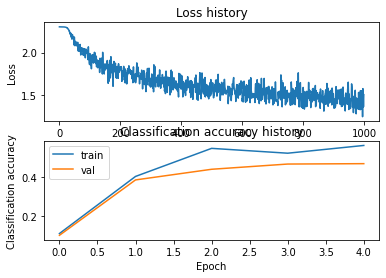

In [10]:
class ShallowNeuralNet(object):
    # Implementing two layer nets
    def __init__(self, input_size, hidden_size, output_size, std=1e-4):

        """
        W1 : first layer weights, shape (D, H)
        b1 : first layer biases, shape (H, )
        W2 : second layer weights, shape (H, C)
        b2 : second layer biases, shape (C, )
        """

        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def loss(self, X, y=None, reg=0.0):
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        # Forward propagation
        Z1 = X @ W1 + b1
        A1 = np.maximum(0, Z1)  # Relu
        Z2 = A1 @ W2 + b2

        if y is None:
            scores = Z2
            return scores

        Z2 -= np.max(Z2, axis=1, keepdims=True)
        Z2_exp = np.exp(Z2)
        scores = Z2_exp / np.sum(Z2_exp, axis=1, keepdims=True)
        loss = np.sum(-np.log(scores[np.arange(N), y]))
        loss /= N
        loss += reg * (np.sum(W2 * W2) + np.sum(W1 * W1))

        # Backward propagation
        grads = {}
        scores[np.arange(N), y] -= 1
        scores /= N

        # W2 gradient
        dW2 = A1.T @ scores

        # b2 gradient
        db2 = scores.sum(axis=0)

        # W1 gradient
        dA1 = scores @ (W2.T)
        dZ1 = dA1 * (Z1 > 0)
        dW1 = X.T @ dZ1

        # b1 gradient
        db1 = dZ1.sum(axis=0)

        # regularization gradient
        dW1 += reg * 2 * W1
        dW2 += reg * 2 * W2

        grads = {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2}

        return loss, grads

    def fit(self, X, y, X_val, y_val, lr=1e-3, lr_decay=0.95, reg=5e-6, num_iters=100, batch_size=200, verbose=False):
        num_train = X.shape[0]
        print(X.shape)
        iter_per_epoch = max(num_train / batch_size, 1)
        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for iter in range(num_iters):
            X_batch = None
            y_batch = None

            batches_indices = np.random.choice(num_train, batch_size)
            X_batch = X[batches_indices]
            y_batch = y[batches_indices]

            # Compute loss and gradients using the current batches
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)

            # Update parameters
            for key in self.params:
                self.params[key] -= lr * grads[key]

            if verbose and iter % 100 == 0:
                print('iteration %d / %d: loss %f' % (iter, num_iters, loss))

            # Every epoch, check train and val accuracy and decay learning rate
            if iter % iter_per_epoch == 0:
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Decay learning rate
                lr *= lr_decay

        return {
                'loss_history': loss_history,
                'train_acc_history': train_acc_history,
                'val_acc_history': val_acc_history
                }

    def predict(self, X):
        y_preds = np.argmax(self.loss(X), axis=1)
        return y_preds



X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10

net = ShallowNeuralNet(input_size, hidden_size, num_classes)

# Train the network

model = net.fit(X_train, y_train, X_val, y_val, num_iters=1000, batch_size=200, verbose=True)
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(model['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(model['train_acc_history'], label='train')
plt.plot(model['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

## DeepNet

In [11]:
class DeepNet(object):
    def __init__(self, hidden_layers, input_size=3*32*32, num_classes=10, reg=0.0, std=1e-2):
        layers = np.hstack([input_size, hidden_layers, num_classes])
        self.params = {}
        self.reg = reg
        self.num_layers = 1 + len(hidden_layers)
        for i in range(self.num_layers):
            self.params['W'+str(i+1)] = std*np.random.randn(layers[i], layers[i+1])
            self.params['b'+str(i+1)] = np.zeros(layers[i+1])
        for k, v in self.params.items():
            self.params[k] = v.astype(np.float32)

    def loss(self, X, y=None):
        x = X.astype(np.float32)
        mode = 'test' if y is None else 'train'
        scores = None
        caches = []
        for i in range(self.num_layers - 1):
            w = self.params['W'+str(i+1)]
            b = self.params['b'+str(i+1)]
            Z, linear_cache = linear_forward(x, w, b)
            A, relu_cache = relu_forward(Z)
            x, cache = A, (linear_cache, relu_cache)
            caches.append(cache)
        w = self.params['W'+str(self.num_layers)]
        b = self.params['b'+str(self.num_layers)]
        scores, cache = linear_forward(x, w, b)
        caches.append(cache)

        if mode == 'test':
            return scores

        # Calculate loss
        loss, grads = 0.0, {}
        loss, softmax_grad = softmax_loss(scores, y)
        for i in range(self.num_layers):
            w = self.params['W'+str(i+1)]
            loss += 0.5 * self.reg * np.sum(w * w)

        # Calculate gradient
        dout = softmax_grad
        dout, dw, db = linear_backward(dout, caches[self.num_layers - 1])
        grads['W'+str(self.num_layers)] = dw + self.reg * self.params['W'+str(self.num_layers)]
        grads['b'+str(self.num_layers)] = db

        for i in range(self.num_layers - 2, -1, -1):
            linear_cache, relu_cache = caches[i]
            # relu
            dout = relu_backward(dout, relu_cache)
            # linear
            dx, dw, db = linear_backward(dout, linear_cache)
            grads['W'+str(i+1)] = dw + self.reg * self.params['W'+str(i+1)]
            grads['b'+str(i+1)] = db
            dout = dx

        return loss, grads

## Classifier

In [51]:
class Classifier(object):
    def __init__(self, model, data, **kwargs):
        self.model = model
        self.X_train = data['X_train']
        self.y_train = data['y_train']
        self.X_val = data['X_val']
        self.y_val = data['y_val']

        # Keyword arguments
        self.lr_decay = kwargs.pop('lr_decay', 1.0)
        self.batch_size = kwargs.pop('batch_size', 100)
        self.num_epochs = kwargs.pop('num_epochs', 10)
        self.num_train_samples = kwargs.pop('num_train_samples', 1000)
        self.num_val_samples = kwargs.pop('num_val_samples', None)
        self.update_rule = kwargs.pop('update_rule', 'sgd')
        self.optim_config = kwargs.pop('optim_config', {})
        self.print_every = kwargs.pop('print_every', 10)
        self.verbose = kwargs.pop('verbose', True)

        if len(kwargs) > 0:
            extra = ', '.join('"%s"' % k for k in list(kwargs.keys()))
            raise ValueError('Unrecognized arguments %s' % extra)

        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d
        self.update_rule = getattr(optimizer, self.update_rule)

    def step(self):
        # Make a minibatch of training
        num_train = self.X_train.shape[0]
        mask = np.random.choice(num_train, self.batch_size)
        X_batch = self.X_train[mask]
        y_batch = self.y_train[mask]

        # Compute loss and gradients
        loss, grads = self.model.loss(X_batch, y_batch)
        self.loss_history.append(loss)

        # Update parameters
        for p, w in self.model.params.items():
            dw = grads[p]
            config = self.optim_configs[p]
            w_new, config_new = self.update_rule(w, dw, config)
            self.model.params[p] = w_new
            self.optim_configs[p] = config_new

    def fit(self):
        num_train = self.X_train.shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        num_iters = self.num_epochs * iterations_per_epoch

        for i in range(num_iters):
            self.step()

            # Print training loss
            if self.verbose and i % self.print_every == 0:
                print('(Iteration %d / %d) loss: %f' % (
                       i + 1, num_iters, self.loss_history[-1]))

            # At the end of every epoch, increase the epoch counter and
            # decay learning rate
            epoch_end = ((i + 1) % iterations_per_epoch == 0)
            if epoch_end:
                self.epoch += 1
                for k in self.optim_configs:
                    self.optim_configs[k]['learning_rate'] *= self.lr_decay
            # Check train and val accuracy on the first iteration, the last iteration, and
            # at the end of each epoch
            first_iters = (i == 0)
            last_iters = (i == num_iters - 1)
            if first_iters or last_iters or epoch_end:
                train_acc = self.accuracy(self.X_train, self.y_train, num_samples=self.num_train_samples)
                val_acc = self.accuracy(self.X_val, self.y_val, num_samples=self.num_val_samples)
                self.train_acc_history.append(train_acc)
                self.val_acc_history.append(val_acc)

                if self.verbose:
                    print('(Epoch %d / %d) train acc: %f; val_acc: %f' % (
                           self.epoch, self.num_epochs, train_acc, val_acc))

                # Keep track of the best model
                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    self.best_params = {}
                    for k, v in self.model.params.items():
                        self.best_params[k] = v.copy()

        # At the end of training swap the best params into the model
        self.model.params = self.best_params

    def accuracy(self, X, y, num_samples=None, batch_size=100):
        """
        X: data, of shape (N, d_1, d_2, ..., d_k)
        y: labels, of shape(N, )
        num_samples: if not None, subsample the data and only test the model one num_samples
                        datapoints
        batch_size: split X and y into batches to avoid too much memmory
        """
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]

        num_batches = N // batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = self.model.loss(X[start:end])
            y_pred.append(np.argmax(scores, axis=1))
        y_pred = np.hstack(y_pred)
        acc = np.mean(y_pred == y)
        return float(acc)

## Final

In [52]:
data = get_CIFAR10_data()

num_train = 100
small_data = {
    'X_train': data[0][:num_train],
    'y_train': data[1][:num_train],
    'X_val': data[2],
    'y_val': data[3],
}

weight_scale = 2e-4
learning_rate = 3e-1

# Create model
model = DeepNet([100, 100, 100, 200], std=weight_scale)
machine = Classifier(model, small_data, print_every=10,
                     num_epochs=20, batch_size=25,
                     update_rule='sgd',
                     optim_config={'learning_rate': learning_rate})
# Train model
machine.fit()
plt.plot(machine.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

NameError: ignored

In [ ]:
|